<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#core-microbiome" data-toc-modified-id="core-microbiome-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>core microbiome</a></span></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# Load the Kang et al fecal transplant data
# week0 vs control
week0_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
kang0_diffs = extract_differentials(week0_fname)
week0_stats = ranking(kang0_diffs, reference_percentile=80)
# week0 vs donor
donor_fname = f'{kang_directory}/donor_ogu/differentials-v8.nc'
donor_diffs = extract_differentials(donor_fname)
donor_stats = ranking(donor_diffs, reference_percentile=80)
# week 0 vs week 105
fmt_fname = f'{kang_directory}/fmt10_ogu/differentials-v8.nc'
kang_0_10_diffs = extract_differentials(fmt_fname)
week_0_10_stats = ranking(kang_0_10_diffs, reference_percentile=80)
# week 0 vs week 18
fmt_fname = f'{kang_directory}/fmt18_ogu/differentials-v8.nc'
kang_0_18_diffs = extract_differentials(fmt_fname)
week_0_18_stats = ranking(kang_0_18_diffs, reference_percentile=80)
# week 0 vs week100
fmt_fname = f'{kang_directory}/fmt100_ogu/differentials-v8.nc'
kang_0_100_diffs = extract_differentials(fmt_fname)
week_0_100_stats = ranking(kang_0_100_diffs, reference_percentile=80)

# cross-sectional results
ast = pd.read_csv('../results/amp-crossectional.csv', index_col=0)
ast.index = list(map(str, ast.index))

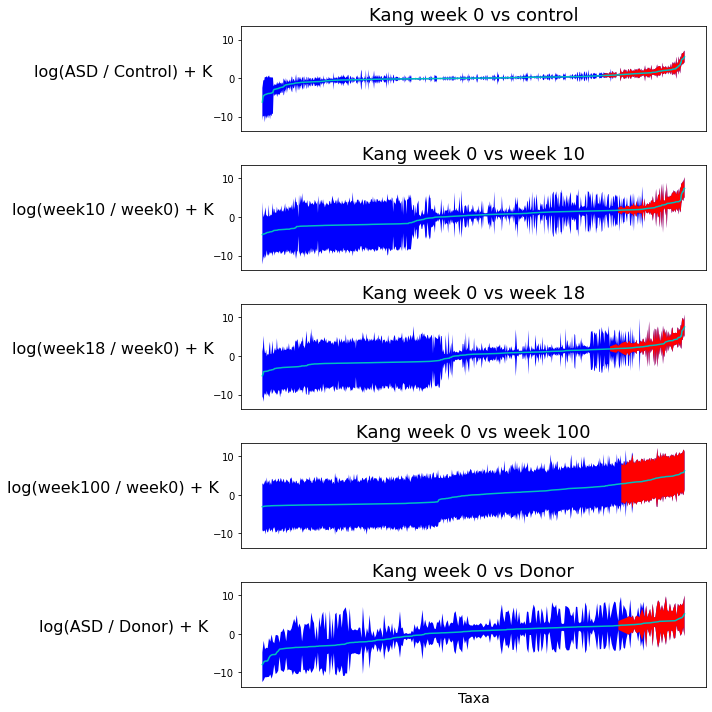

In [3]:
# Plot differentials
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharey=True)
rankplot(week0_stats, ax[0])
ax[0].set_title('Kang week 0 vs control', fontsize=18)
ax[0].set_xticks([])
ax[0].set_ylabel('log(ASD / Control) + K', fontsize=16, 
                 rotation=0, labelpad=90)
rankplot(week_0_10_stats, ax[1])
ax[1].set_title('Kang week 0 vs week 10', fontsize=18)
ax[1].set_ylabel('log(week10 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[1].set_xticks([])
rankplot(week_0_18_stats, ax[2])
ax[2].set_title('Kang week 0 vs week 18', fontsize=18)
ax[2].set_ylabel('log(week18 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[2].set_xticks([])
rankplot(week_0_100_stats, ax[3])
ax[3].set_title('Kang week 0 vs week 100', fontsize=18)
ax[3].set_ylabel('log(week100 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[3].set_xticks([])

rankplot(donor_stats, ax[4])
ax[4].set_title('Kang week 0 vs Donor', fontsize=18)
ax[4].set_xticks([])
ax[4].set_ylabel('log(ASD / Donor) + K', fontsize=16, 
                 rotation=0, labelpad=90)
ax[4].set_xlabel('Taxa', fontsize=14)
plt.tight_layout()

Map the 16S reads to whole genomes

In [4]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

Merge mappings with rankings

In [5]:
week0_stats_gotu = pd.merge(week0_stats, mapping, left_index=True, right_index=True)
week0_10_stats_gotu = pd.merge(week_0_10_stats, mapping, left_index=True, right_index=True)
week0_18_stats_gotu = pd.merge(week_0_18_stats, mapping, left_index=True, right_index=True)
week0_100_stats_gotu = pd.merge(week_0_100_stats, mapping, left_index=True, right_index=True)
donor_stats_gotu = pd.merge(donor_stats, mapping, left_index=True, right_index=True)

week0_stats_gotu.to_csv('../results/week0_fmt_ranks.csv')
week0_10_stats_gotu.to_csv('../results/week0_10_fmt_ranks.csv')
week0_18_stats_gotu.to_csv('../results/week0_18_fmt_ranks.csv')
week0_100_stats_gotu.to_csv('../results/week0_100_fmt_ranks.csv')
donor_stats_gotu.to_csv('../results/week0_donor_fmt_ranks.csv')

Read in top taxa determined from meta-disease analysis

In [6]:
top_taxa_mappings = {}
set_names = ['core', 't1d_', 'ibd_', 'asd_', 'asd_ibd', 'asd_t1d', 'ibd_t1d']
for s in set_names:
    top_taxa_mappings[s] = pd.read_csv(f'../results/{s}_taxa_set.csv', dtype=str)

In [7]:
asd_specific = set(top_taxa_mappings['asd_']['genome'].values)

asd_t1d = set(top_taxa_mappings['asd_t1d']['genome'].values)
asd_ibd = set(top_taxa_mappings['asd_ibd']['genome'].values)
core = set(top_taxa_mappings['core']['genome'].values)

asd_taxa = asd_t1d | asd_ibd | core

In [8]:
genomes = set(mapping.index)
asd_specific_mapping = mapping.loc[genomes & asd_specific].index
asd_mapping = mapping.loc[genomes & asd_taxa].index

In [9]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

Create heatmap of all time points

In [10]:
all_diffs = pd.DataFrame({
    'week0_control' : week0_stats.reindex(asd_specific_mapping)['mean'],
    'week0_10' : week_0_10_stats.reindex(asd_specific_mapping)['mean'],
    'week0_18' : week_0_18_stats.reindex(asd_specific_mapping)['mean'],
    'week0_100' : week_0_100_stats.reindex(asd_specific_mapping)['mean'],
    'week0_donor' : donor_stats.reindex(asd_specific_mapping)['mean']
})


all_diffs = all_diffs.sort_values('week0_control')
all_diffs = pd.merge(all_diffs, mapping, left_index=True, right_index=True)

all_diffs = all_diffs.reset_index().set_index('species')
#all_diffs = all_diffs.loc[all_diffs['week0_control'] > 0]

a1 = all_diffs[['week0_control', 'week0_10','week0_18', 'week0_100', 'week0_donor']].drop_duplicates()
idx = pd.isnull(a1).sum(axis=1) < 5  # only focus on microbes in kang et al
a1 = a1.loc[idx]
a1 = a1.sort_values('week0_control')
a1.to_csv('../results/asd_specific_microbiome_fmt.csv')

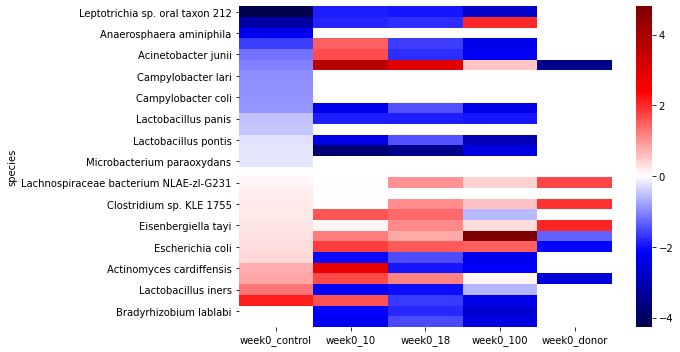

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(a1, ax=ax, cmap='seismic', norm=MidpointNormalize(vcenter=0))
#ax.imshow(a1.values, interpolation='none', aspect='auto', cmap='seismic', norm=MidpointNormalize(vcenter=0))
plt.tight_layout()
a1.to_csv('../results/week0_control_fmt.csv')
fig.savefig('../results/week0_control_fmt.png')

In [12]:
all_diffs = all_diffs[['week0_10', 'week0_18', 'week0_100']].dropna()
diff_data = pd.melt(all_diffs.reset_index(), id_vars='species', value_name='log_fold_change')
diff_data['week'] = diff_data['variable'].apply(lambda x: float(x.split('_')[1]))

# add zeros for week 0
species = diff_data.species.value_counts().index
dat = pd.DataFrame({'species': species, 'variable': ['week0'] * len(species),
                    'log_fold_change': np.zeros(len(species)), 
                    'week': np.zeros(len(species))})

asd_diffs = pd.concat((diff_data, dat))

extinct = set(all_diffs.loc[all_diffs['week0_100'] < -2].index)
asd_diffs['extinct'] = asd_diffs['species'].apply(lambda x: x in extinct)

Text(0.5, 1.0, 'ASD-specific taxa (pre-FMT)')

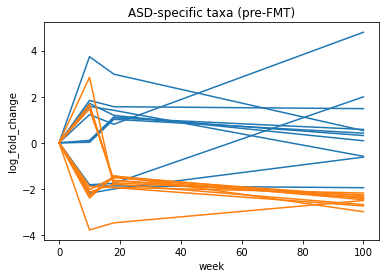

In [13]:
sns.lineplot(data=asd_diffs, x='week', y='log_fold_change', units='species', hue='extinct', 
             legend=False, estimator=None)
plt.title('ASD-specific taxa (pre-FMT)')

# core microbiome

In [14]:
all_diffs = pd.DataFrame({
    'week0_control' : week0_stats.reindex(asd_mapping)['mean'],
    'week0_10' : week_0_10_stats.reindex(asd_mapping)['mean'],
    'week0_18' : week_0_18_stats.reindex(asd_mapping)['mean'],
    'week0_100' : week_0_100_stats.reindex(asd_mapping)['mean'],
    'week0_donor' : donor_stats.reindex(asd_mapping)['mean']
})


all_diffs = all_diffs.sort_values('week0_control')
all_diffs = pd.merge(all_diffs, mapping, left_index=True, right_index=True)
all_diffs = all_diffs.set_index('species').drop_duplicates()
#all_diffs = all_diffs.loc[all_diffs['week0_control'] > 0]

a1 = all_diffs[['week0_control', 'week0_10','week0_18', 'week0_100', 'week0_donor']]
idx = pd.isnull(a1).sum(axis=1) < 5  # only focus on microbes in kang et al
a1 = a1.loc[idx]
a1 = a1.sort_values('week0_control')
a1.to_csv('../results/asd_core_microbiome_fmt.csv')

In [15]:
all_diffs

,week0_control,week0_10,week0_18,week0_100,week0_donor,GOTU,kingdom,phylum,class,order,family,genus
species,,,,,,,,,,,,
Propionibacterium acidifaciens,NaN,NaN,NaN,NaN,NaN,G000426605,Bacteria,Actinobacteria,Actinobacteria,Propionibacteriales,Propionibacteriaceae,Propionibacterium
Pseudomonas balearica,NaN,NaN,NaN,NaN,NaN,G900103375,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
Halobiforma nitratireducens,NaN,NaN,NaN,NaN,NaN,G000337895,Archaea,Euryarchaeota,Halobacteria,Natrialbales,Natrialbaceae,Halobiforma
Natronorubrum sulfidifaciens,NaN,NaN,NaN,NaN,NaN,G000337735,Archaea,Euryarchaeota,Halobacteria,Natrialbales,Natrialbaceae,Natronorubrum
Weissella ceti,NaN,NaN,NaN,NaN,NaN,G000320345,Bacteria,Firmicutes,Bacilli,Lactobacillales,Leuconostocaceae,Weissella
Bacteroides faecis CAG:32,NaN,NaN,NaN,NaN,NaN,G000433375,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Bacteroides fragilis,0.018063,1.786732,2.212463,3.819405,1.829757,G000598465,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Bacteroides fragilis,-0.013567,1.149618,1.598277,4.867412,1.762507,G000598965,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Vibrio diazotrophicus,NaN,NaN,NaN,NaN,NaN,G000740015,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio


In [16]:
all_diffs = all_diffs[['week0_10', 'week0_18', 'week0_100']].dropna()
diff_data = pd.melt(all_diffs.reset_index(), id_vars='species', value_name='log_fold_change')
diff_data['week'] = diff_data['variable'].apply(lambda x: float(x.split('_')[1]))

# add zeros for week 0
species = diff_data.species.value_counts().index
dat = pd.DataFrame({'species': species, 'variable': ['week0'] * len(species),
                    'log_fold_change': np.zeros(len(species)), 
                    'week': np.zeros(len(species))})
core_diffs = pd.concat((diff_data, dat))

extinct = set(all_diffs.loc[all_diffs['week0_100'] < -2].index)
core_diffs['extinct'] = core_diffs['species'].apply(lambda x: x in extinct)

Text(0.5, 1.0, 'Core disease taxa (pre-FMT)')

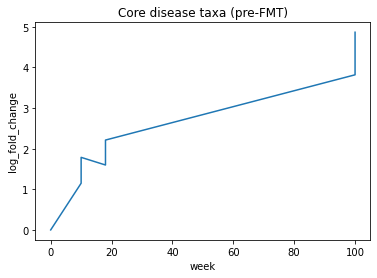

In [17]:
sns.lineplot(data=core_diffs, x='week', y='log_fold_change', units='species', hue='extinct', 
             legend=False, estimator=None)
plt.title('Core disease taxa (pre-FMT)')

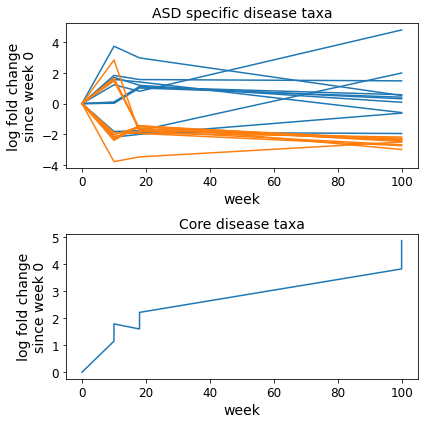

In [18]:
# sns.set_style('whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
sns.lineplot(data=asd_diffs, x='week', y='log_fold_change', units='species', hue='extinct', 
             legend=False, estimator=None, ax=ax[0])
sns.lineplot(data=core_diffs, x='week', y='log_fold_change', units='species', hue='extinct', 
             legend=False, estimator=None, ax=ax[1])

ax[0].set_title('ASD specific disease taxa', fontsize=14)
ax[1].set_title('Core disease taxa', fontsize=14)

ax[0].set_ylabel('log fold change\nsince week 0', fontsize=14)
ax[1].set_ylabel('log fold change\nsince week 0', fontsize=14)

ax[0].set_xlabel('week', fontsize=14)
ax[1].set_xlabel('week', fontsize=14)

ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()

Let's try to set a common reference

In [19]:
all_diffs = pd.DataFrame({
    'week0_control' : week0_stats['mean'],
    'week0_10' : week_0_10_stats['mean'],
    'week0_18' : week_0_18_stats['mean'],
    'week0_100' : week_0_100_stats['mean'],
    'week0_donor' : donor_stats['mean']
})

# compute control reference
#idx = all_diffs['week0_control'] < -1
#control_taxa = all_diffs.loc[idx].index
idx = ast['cluster_name'] == 'neutral'
control_taxa = list(set(ast.loc[idx].index) & set(all_diffs.index))
control_ref = all_diffs.loc[control_taxa, ['week0_10', 'week0_18', 'week0_100']].dropna().mean(axis=0)

#all_diffs = all_diffs.dropna()
all_diffs = all_diffs.sort_values('week0_control')
all_diffs = pd.merge(all_diffs, mapping, left_index=True, right_index=True)
#all_diffs = all_diffs.set_index('species').drop_duplicates()

In [20]:
all_diffs.reset_index()

,index,week0_control,week0_10,week0_18,week0_100,week0_donor,GOTU,kingdom,phylum,class,order,family,genus,species
0,1000569,0.918512,NaN,NaN,NaN,NaN,G000221545,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Megasphaera,Megasphaera sp. UPII 135-E
1,1002367,-1.735105,-1.733505,-1.474907,-2.079815,NaN,G000235885,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea
2,1006000,-1.876858,NaN,NaN,NaN,NaN,G000735365,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Kluyvera,Kluyvera ascorbata
3,1007096,-0.429017,0.872184,1.739806,1.160871,0.441728,G000307265,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter ruminantium
4,1008459,-2.876159,-2.099797,-1.945139,-2.647965,NaN,G000226625,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Taylorella,Taylorella asinigenitalis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,997894,-0.134230,-0.752129,0.870629,1.945406,1.299181,G000371705,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,[Clostridium] bolteae
949,999386,2.290622,-1.992338,1.857199,-2.612250,NaN,G000204195,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Acidovorax,Acidovorax radicis
950,999411,3.162380,NaN,NaN,NaN,NaN,G000371465,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,Clostridium colicanis
951,999413,-0.153877,0.408429,0.498035,1.992661,2.102394,G000371425,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Erysipelatoclostridium,[Clostridium] innocuum


<AxesSubplot:xlabel='week', ylabel='log_fold_change'>

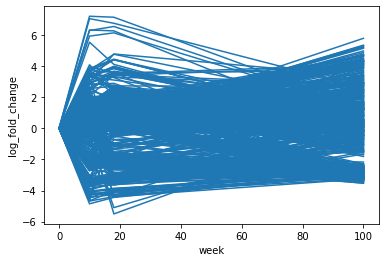

In [21]:
all_diffs = all_diffs[['week0_10', 'week0_18', 'week0_100']].dropna()
all_diffs = all_diffs - control_ref  # standardize across common reference

#col_name = 'species'
col_name = 'index'
diff_data = pd.melt(all_diffs.reset_index(), id_vars=col_name, value_name='log_fold_change')
diff_data['week'] = diff_data['variable'].apply(lambda x: float(x.split('_')[1]))

# add zeros for week 0
species = diff_data[col_name].value_counts().index
dat = pd.DataFrame({col_name: species, 'variable': ['week0'] * len(species),
                    'log_fold_change': np.zeros(len(species)), 
                    'week': np.zeros(len(species))})
core_diffs = pd.concat((diff_data, dat))

extinct = set(all_diffs.loc[all_diffs['week0_100'] < 0].index)
core_diffs['extinct'] = core_diffs[col_name].apply(lambda x: x in extinct)

asd_species = set(list(mapping.loc[asd_specific].species.values))
core_diffs['asd_specific'] = core_diffs[col_name].apply(lambda x: x in asd_species)
sns.lineplot(data=core_diffs, x='week', y='log_fold_change', units=col_name, hue='asd_specific', 
             legend=False, estimator=None)

CARS analysis

In [22]:
kang_md = pd.read_excel(f'{kang_directory}/Kang_et_al_2019_metadata.xlsx', 
                        sheet_name='general data', skiprows=2)

cars = kang_md.iloc[:18, 19:26][['Baseline', 'week 10', 'week 18', '2-year']]
cars.index = kang_md.Code[:18]

cars_df = pd.melt(cars.reset_index(), id_vars=['Code'], var_name='timepoint', value_name='CARS')
time_lookup = {
    'week 10': 10,
    'week 18': 18,
    '2-year': 100,
    'Baseline': 0
}
cars_df['weeks'] = cars_df.timepoint.apply(lambda x: time_lookup[x])

<AxesSubplot:xlabel='weeks', ylabel='CARS'>

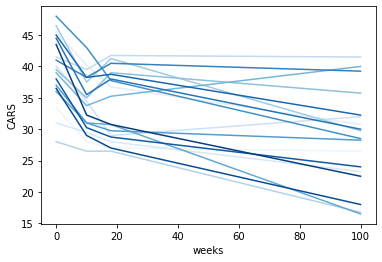

In [23]:
sns.lineplot(data=cars_df, hue='Code', x='weeks', y='CARS', palette='Blues', legend=False)

In [24]:
cars_first = cars_df.groupby('Code').first()
cars_last = cars_df.groupby('Code').last()
cars_first

,timepoint,CARS,weeks
Code,,,
B101,Baseline,33.5,0
B103,Baseline,45.5,0
B105,Baseline,31.0,0
B107,Baseline,40.0,0
B109,Baseline,41.5,0
B111,Baseline,28.0,0
B113,Baseline,46.5,0
B115,Baseline,39.5,0
B117,Baseline,39.0,0


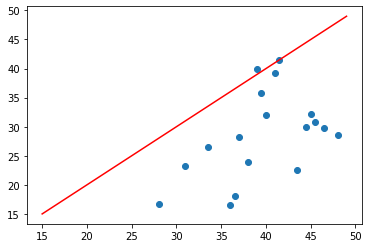

In [25]:
plt.scatter(cars_first['CARS'], cars_last['CARS'])
plt.plot(np.arange(15, 50), np.arange(15, 50), 'r')

In [26]:
all_diffs = all_diffs[['week0_10', 'week0_18', 'week0_100']].dropna()
all_diffs = all_diffs - control_ref  # standardize across common reference

diff_data = pd.melt(all_diffs.reset_index(), id_vars=col_name, value_name='log_fold_change')
diff_data['week'] = diff_data['variable'].apply(lambda x: float(x.split('_')[1]))

# add zeros for week 0
species = diff_data[col_name].value_counts().index
dat = pd.DataFrame({col_name: species, 'variable': ['week0'] * len(species),
                    'log_fold_change': np.zeros(len(species)), 
                    'week': np.zeros(len(species))})
core_diffs = pd.concat((diff_data, dat))

extinct = set(all_diffs.loc[all_diffs['week0_100'] < 0].index)
core_diffs['extinct'] = core_diffs[col_name].apply(lambda x: x in extinct)
core_diffs = pd.merge(core_diffs, ast, left_on='index', right_index=True)

asd_species = set(ast.loc[ast.cluster_name == 'num'].index)
con_species = set(ast.loc[ast.cluster_name == 'denom'].index)

def lr_f(x):
    if x in asd_species:
        return 'ASD'
    elif x in con_species:
        return 'Control'
    return 'Neutral'

core_diffs['asd_specific'] = core_diffs['species'].apply(lambda x: x in asd_species)
core_diffs['lr_group'] = core_diffs[col_name].apply(lr_f)

def group_f(x):
    order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 'Desulfovibrio']
    for o in order:
        if o in x['species']:
            return o
    return 'Other'
core_diffs['groups'] = core_diffs.apply(group_f, axis=1) 

In [27]:
core_diffs

,index,variable,log_fold_change,week,extinct,mean,std,5%,50%,95%,...,kingdom,phylum,class,order,family,genus,species,asd_specific,lr_group,groups
0,1002367,week0_10,-2.245950,10.0,True,-1.735105,0.202655,-2.045767,-1.751642,-1.398189,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea,False,Control,Prevotella
711,1002367,week0_18,-2.228763,18.0,True,-1.735105,0.202655,-2.045767,-1.751642,-1.398189,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea,False,Control,Prevotella
1422,1002367,week0_100,-3.052064,100.0,True,-1.735105,0.202655,-2.045767,-1.751642,-1.398189,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea,False,Control,Prevotella
410,1002367,week0,0.000000,0.0,True,-1.735105,0.202655,-2.045767,-1.751642,-1.398189,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella stercorea,False,Control,Prevotella
1,1007096,week0_10,0.359739,10.0,False,-0.429017,0.114861,-0.612542,-0.429220,-0.234517,...,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter ruminantium,False,Neutral,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,999413,week0,0.000000,0.0,False,-0.153877,0.099570,-0.313052,-0.158624,0.013847,...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Erysipelatoclostridium,[Clostridium] innocuum,False,Neutral,Other
710,999419,week0_10,1.414286,10.0,False,-0.419025,0.072246,-0.528602,-0.424125,-0.299116,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,Parabacteroides johnsonii,False,Neutral,Other
1421,999419,week0_18,1.521705,18.0,False,-0.419025,0.072246,-0.528602,-0.424125,-0.299116,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,Parabacteroides johnsonii,False,Neutral,Other
2132,999419,week0_100,4.155841,100.0,False,-0.419025,0.072246,-0.528602,-0.424125,-0.299116,...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,Parabacteroides johnsonii,False,Neutral,Other


Text(0.5, 0, 'Weeks')

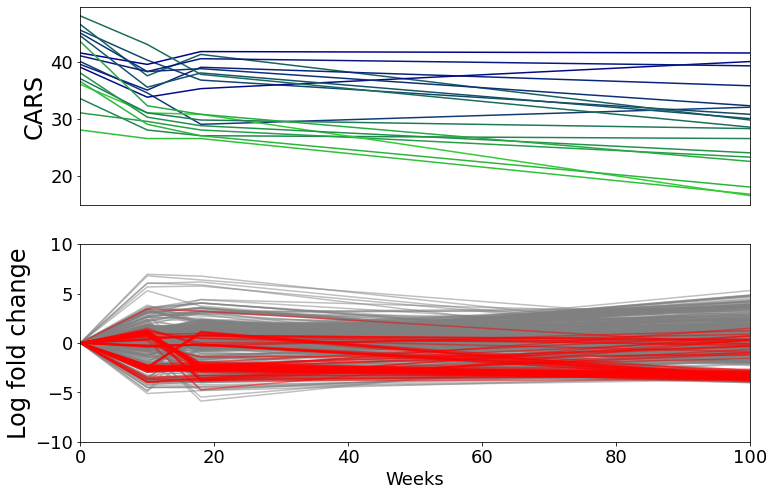

In [28]:
#asd_species = set(list(mapping.loc[asd_specific].species.values))
#core_diffs['asd_specific'] = core_diffs['species'].apply(lambda x: x in asd_species)
# sns.set(font_scale=1)
#sns.set_style('whitegrid')

#with plt.style.context('dark_background'):
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(data=core_diffs, x='week', y='log_fold_change', units=col_name, hue='lr_group', 
             palette={'ASD': 'r', 'Neutral':'#808080', 'Control': 'g'},
             legend=False, estimator=None, ax=ax[1], alpha=0.5)
sns.lineplot(data=core_diffs.loc[core_diffs.asd_specific],
             x='week', y='log_fold_change', units=col_name, hue='lr_group', 
             palette={'ASD': 'r', 'Neutral':'#808080', 'Control': 'g'},
             legend=False, estimator=None, ax=ax[1])

subjects = cars_df.loc[cars_df.timepoint == '2-year'].sort_values('CARS').Code
#cmap = sns.color_palette('winter', 18)
cmap = sns.blend_palette(["limegreen", "darkblue"], 18) 
palette = dict(zip(subjects, list(cmap)))
sns.lineplot(data=cars_df, hue='Code', x='weeks', y='CARS', palette=palette,
             legend=False, ax=ax[0])
ax[0].set_xlim([0, 100])
ax[1].set_ylim([-10, 10])
ax[1].set_xlim([0, 100])
ax[1].set_ylabel('log fold change')
ax[0].set_xticks([])
ax[0].set_xlabel("")

ax[0].set_ylabel("CARS", fontsize=24)
ax[1].set_ylabel("Log fold change", fontsize=24)

ax[0].tick_params(labelsize=18, axis='y')
ax[1].tick_params(labelsize=18, axis='y')

ax[1].tick_params(labelsize=18, axis='x')
ax[1].set_xlabel('Weeks', fontsize=18)

Create a separate group assignment

In [29]:
def cars_group(x):
    if x < 30:
        return 'normal'
    if x < 37:
        return 'mild'
    return 'severe'


idx = cars_df['weeks'] == 100
cars_end = cars_df.loc[idx]
cars_end['group'] = cars_end.CARS.apply(cars_group)
group = cars_end.set_index('Code')['group'].to_dict()
cars_df['group'] = cars_df.Code.apply(lambda x: group[x])

<ipython-input-29-9fb3479583a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_end['group'] = cars_end.CARS.apply(cars_group)


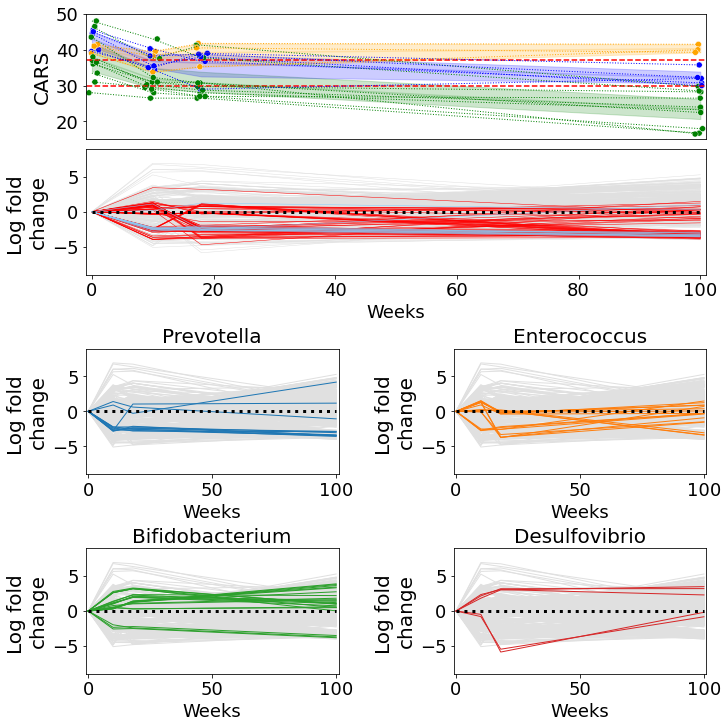

In [30]:
import matplotlib.ticker as plticker


#with plt.style.context('dark_background'):
#fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
gs = GridSpec(4, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax21 = fig.add_subplot(gs[2, 0])
ax22 = fig.add_subplot(gs[2, 1])
ax31 = fig.add_subplot(gs[3, 0])
ax32 = fig.add_subplot(gs[3, 1])

dx = 1
fs = 20
ls = 18

### CARS plots (top)

cars_df['rand_week'] = cars_df['weeks'] + 0.5 * np.random.randn(len(cars_df))

ax0.hlines(30, -10, 150, color='r', linestyle='--')
ax0.hlines(37, -10, 150, color='r', linestyle='--')
sns.lineplot(data=cars_df, hue='group', 
             palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'},
             x='weeks', y='CARS', alpha=0.2, ci=95,
             legend=False, ax=ax0)
sns.lineplot(data=cars_df, #hue='Code', 
             x='weeks', y='CARS', units='Code', estimator=None,
             legend=False, ax=ax0, linestyle=':', linewidth=1, 
             hue='group', palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'})
sns.scatterplot(data=cars_df, #hue='Code', 
              x='rand_week', y='CARS', 
              hue='group', palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'},
              legend=False, ax=ax0)
ax0.set_ylim([15, 50])

loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax0.yaxis.set_major_locator(loc)

ax0.set_ylabel("CARS", fontsize=fs)
ax0.tick_params(labelsize=ls, axis='y')
ax0.set_xlim([-dx, 100 + dx])
ax0.set_xticks([])
ax0.set_xlabel("")


### Microbiome differential plot (middle)
sns.lineplot(data=core_diffs,
             x='week', y='log_fold_change', units=col_name, 
             hue='lr_group', 
             hue_order=['Neutral', 'ASD', 'Control'], 
             lw=0.5,
             palette={'ASD': 'r', 'Neutral':'#E0E0E0', 'Control': '#87cefa'},
             legend=False, estimator=None, ax=ax1)

ax1.set_ylim([-9, 9])
ax1.set_xlim([-dx, 100 + dx])
ax1.set_ylabel("Log fold \nchange", fontsize=fs)
ax1.tick_params(labelsize=ls, axis='x')
ax1.set_xlabel('Weeks', fontsize=ls)
ax1.tick_params(labelsize=ls, axis='y')
ax1.hlines(0, xmin=0, xmax=100, color='k', linewidth=3, linestyle=':', zorder=10)


### Bottom panels
order = ['Other', 'Bifidobacterium', 'Enterococcus', 'Prevotella', 'Desulfovibrio']
bugs = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
        'Desulfovibrio']
axes = [ax21, ax22, ax31, ax32]
palette = dict(zip(bugs, list(sns.color_palette())))
palette['Other'] = '#E0E0E0'

for bug, ax in zip(bugs, axes):
    idx = np.logical_or(core_diffs.genus == bug, core_diffs.groups == 'Other')
    sns.lineplot(data=core_diffs.loc[idx],
                 x='week', y='log_fold_change', units=col_name, hue='groups', 
                 hue_order=order,
                 palette=palette, linewidth=1,
                 legend=False, estimator=None, ax=ax)
    ax.set_title(bug, fontsize=fs)
    ax.set_ylim([-9, 9])
    ax.set_xlim([-dx, 100 + dx])
    ax.set_ylabel("Log fold \nchange", fontsize=fs)
    ax.tick_params(labelsize=ls, axis='y')
    ax.tick_params(labelsize=ls, axis='x')
    ax.set_xlabel('Weeks', fontsize=ls)
    ax.hlines(0, xmin=0, xmax=100, color='k', linewidth=3, 
              linestyle=':', zorder=10)
    
# plt.tight_layout()

In [31]:
core_diffs[['index', 'lr_group']].drop_duplicates().reset_index()['lr_group'].value_counts()

Neutral    524
ASD        106
Control     13
Name: lr_group, dtype: int64

In [32]:
106 / 142

0.7464788732394366

In [33]:
idx = np.logical_and(core_diffs['week'] == 100, core_diffs['lr_group'] == 'ASD')
np.mean(core_diffs.loc[idx, 'log_fold_change'] < 0), len(core_diffs.loc[idx])

(0.8974358974358975, 117)

In [34]:
all_lfc = core_diffs.reset_index()
all_lfc.pop('level_0')
all_lfc.to_csv('../results/supplemental_tables/Table_S13.csv')

In [35]:
core_diffs.groups.value_counts()

Other              2461
Bifidobacterium      92
Enterococcus         71
Prevotella           48
Desulfovibrio        23
Name: groups, dtype: int64

In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 1)

In [ ]:
week100 = core_diffs.loc[core_diffs['variable'] == 'week0_100']
week100.loc[week100['genus'] == 'Bifidobacterium'].sort_values(
    'log_fold_change')[['log_fold_change', 'species']].set_index(
    'species')['log_fold_change']

Granger causality test

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
t0_100 = biom.load_table(f'{kang_directory}/week0_week10_ogu.biom')
t10_100 = biom.load_table(f'{kang_directory}/week0_week18_ogu.biom')
t18_100 = biom.load_table(f'{kang_directory}/week0_week100_ogu.biom')
t = t0_100.merge(t10_100).merge(t18_100)
md = pd.read_table(f'{kang_directory}/sample_metadata.txt', index_col=0)
md = md.loc[t.ids()]

In [ ]:
asd_species = set(ast.loc[ast.cluster_name == 'num'].index.astype(str)) & set(t.ids(axis='observation'))
con_species = set(ast.loc[ast.cluster_name == 'denom'].index.astype(str)) & set(t.ids(axis='observation'))

In [ ]:
tab = t.to_dataframe()
num_lr = np.log(tab.loc[asd_species] + 1).mean(axis=0)
denom_lr = np.log(tab.loc[con_species] + 1).mean(axis=0)
balance = num_lr - denom_lr
md['balance'] = balance

In [ ]:
sns.lineplot(data=md, hue='host_subject_id', x='weeks-since-experiment-start', y='balance', 
             palette='Blues', legend=False)

In [ ]:
cmap = sns.blend_palette(["cornflowerblue", "forestgreen"], 18) 
sns.palplot(cmap)

In [ ]:
# sort by variance
#subjects = cars_df.groupby('Code').var().sort_values('CARS').index
# sort by last timepoint
subjects = cars_df.loc[cars_df.timepoint == '2-year'].sort_values('CARS').Code

In [ ]:
sns.set_style("dark")
subjects = cars_df.loc[cars_df.timepoint == '2-year'].sort_values('CARS').Code
cmap = sns.color_palette('Spectral', 18)
#cmap = sns.blend_palette(["teal", "firebrick"], 18) 

palette = dict(zip(subjects, list(cmap)))
sns.lineplot(data=cars_df.sort_values("CARS"), hue='Code', x='weeks', y='CARS', 
             palette=palette, legend=False)

In [ ]:
md = pd.merge(md, cars_df, left_on=['host_subject_id', 'weeks-since-experiment-start'],
              right_on=['Code', 'weeks'])

In [ ]:
core_subset = core_diffs.loc[core_diffs['variable'] == 'week0_100']
core_subset = core_subset.loc[core_subset.asd_specific]
core_subset.sort_values('log_fold_change').tail(20)

In [ ]:
pd.merge(week0_stats, mapping, left_index=True, right_index=True).to_csv('../results/fmt-week0-control.csv')
pd.merge(week_0_10_stats, mapping, left_index=True, right_index=True).to_csv('../results/fmt-week0-10.csv')
pd.merge(week_0_18_stats, mapping, left_index=True, right_index=True).to_csv('../results/fmt-week0-18.csv')
pd.merge(week_0_100_stats, mapping, left_index=True, right_index=True).to_csv('../results/fmt-week0-100.csv')
pd.merge(donor_stats, mapping, left_index=True, right_index=True).to_csv('../results/fmt-week0-donor.csv')

# Scratch

Core disease taxa (donor)

In [ ]:
donor_diffs